constructorId      int64
constructorRef    object
name              object
nationality       object
url               object
dtype: object
driverId        int64
driverRef      object
number         object
code           object
forename       object
surname        object
dob            object
nationality    object
url            object
dtype: object
resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object
raceId          int64
year            int64
round           int64
circuitId       int64
name           object
date           object
time           ob

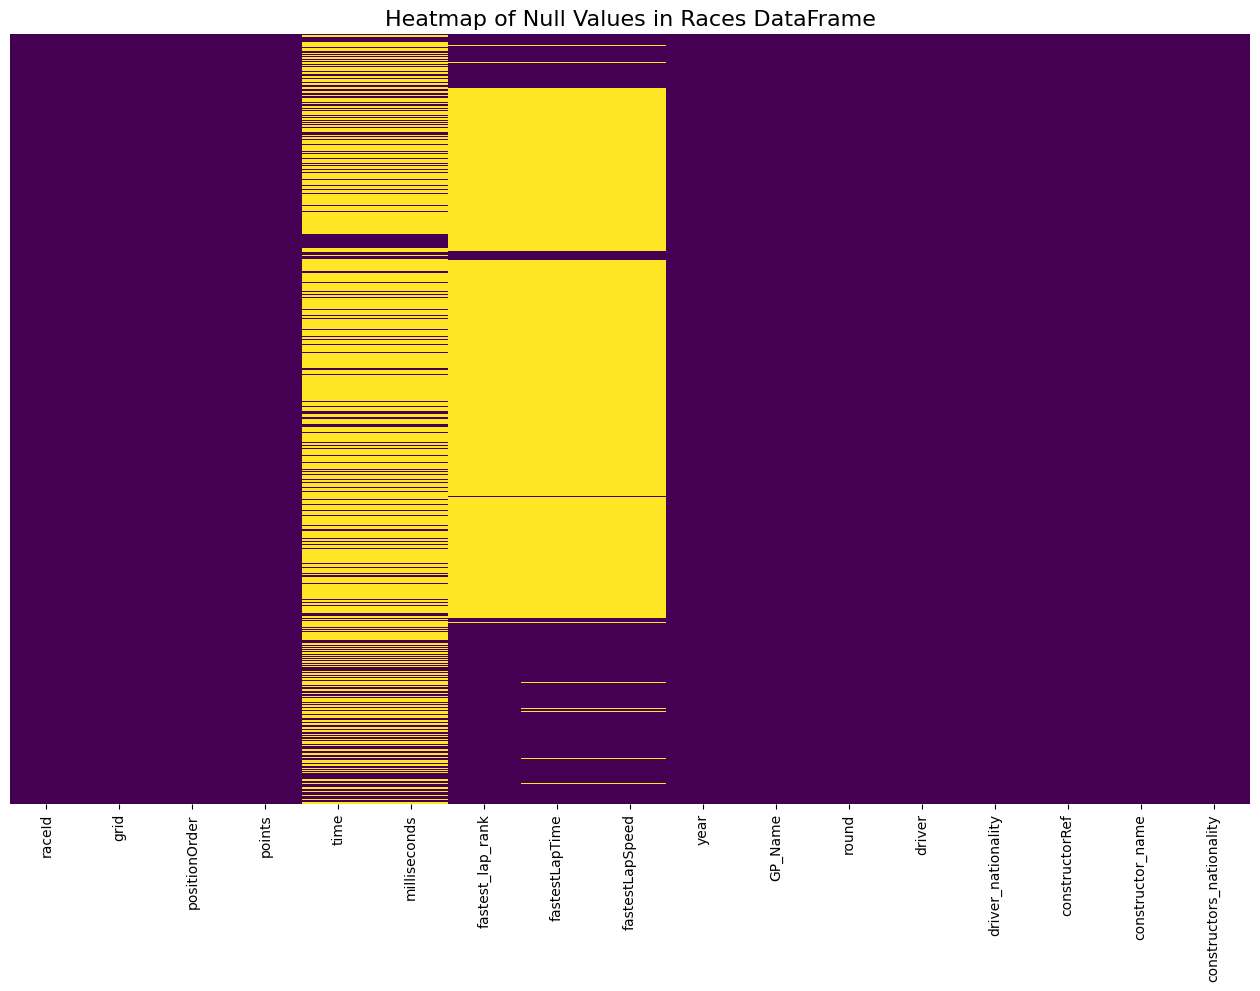

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')
results = pd.read_csv('results.csv')
races=pd.read_csv('races.csv')
imp_df = [constructors, drivers,  results,races]


for df in imp_df:
    df.replace('\\N', np.nan, inplace=True)
    print(df.dtypes)    
    
races.drop(columns=['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],inplace=True)

df=pd.merge(results,races[['raceId','year','name','round']],on='raceId',how='left')
df=pd.merge(df,drivers[['driverId','driverRef','nationality']],on='driverId',how='left')
df=pd.merge(df,constructors[['constructorId','constructorRef','name','nationality']],on='constructorId',how='left')
df.drop(columns=['number','position','positionText','laps','fastestLap','statusId','resultId','driverId','constructorId'],axis=1,inplace=True)

df.rename(columns={'rank':'fastest_lap_rank','name_x':'GP_Name','nationality_x':'driver_nationality','name_y':'constructor_name','nationality_y':'constructors_nationality','driverRef':'driver'},inplace=True)
plt.figure(figsize=(16, 10))

# Create a heatmap to visualize null values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

# Add title and display the heatmap
plt.title('Heatmap of Null Values in Races DataFrame', fontsize=16)
plt.show()

In [6]:

df_transitions_raw = df[['driver', 'constructor_name', 'year']].drop_duplicates()

df_transitions_raw = df_transitions_raw.sort_values(by=['driver', 'year'])

transitions = []

# Loop through each driver to find team changes
for driver in df_transitions_raw['driver'].unique():
    driver_history = df_transitions_raw[df_transitions_raw['driver'] == driver].sort_values('year')
    prev_team = None
    
    for _, row in driver_history.iterrows():
        current_team = row['constructor_name']
        year = row['year']
        
        if prev_team and prev_team != current_team:
            transitions.append({'driver': driver, 'from_team': prev_team, 'to_team': current_team, 'year': year})
        prev_team = current_team

df_transitions = pd.DataFrame(transitions)

print("Driver Transitions Between Teams:")
print(df_transitions.head())


Driver Transitions Between Teams:
    driver           from_team             to_team  year
0    abate        Lotus-Climax             Porsche  1963
1  adamich             Ferrari  McLaren-Alfa Romeo  1970
2  adamich  McLaren-Alfa Romeo    March-Alfa Romeo  1971
3  adamich    March-Alfa Romeo             Surtees  1972
4  adamich             Surtees             Brabham  1973


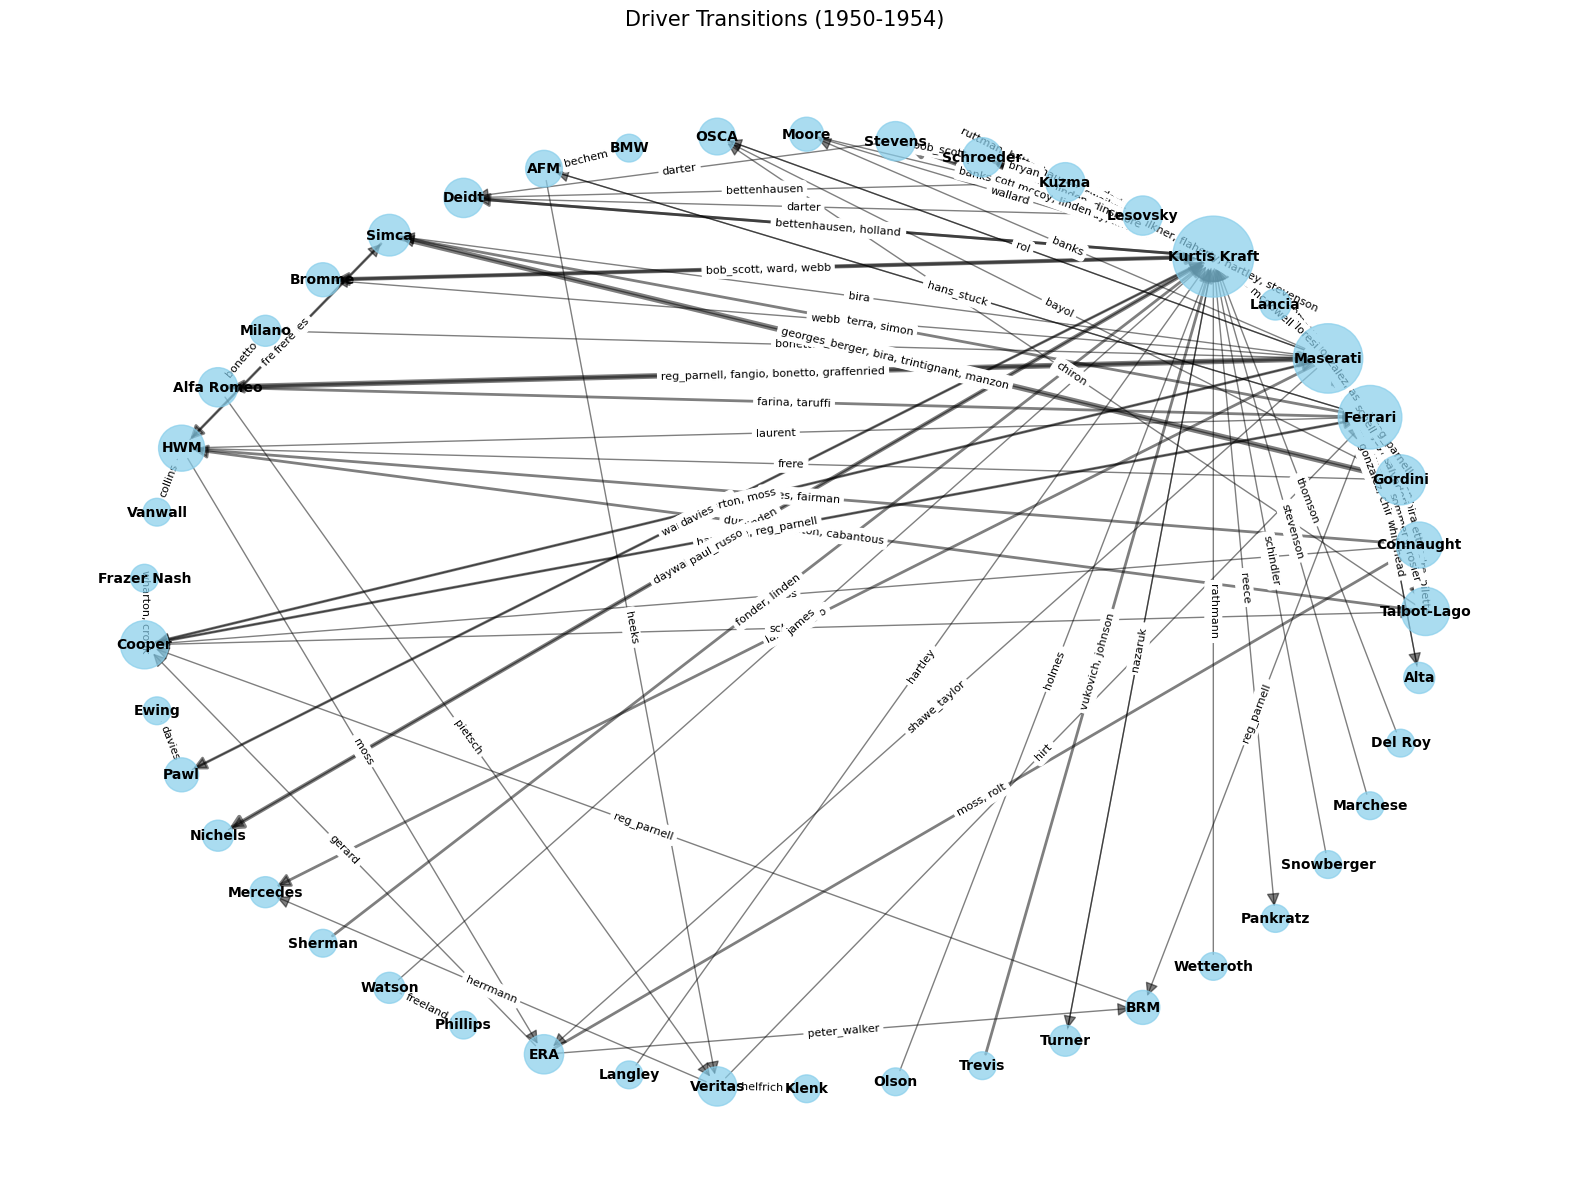

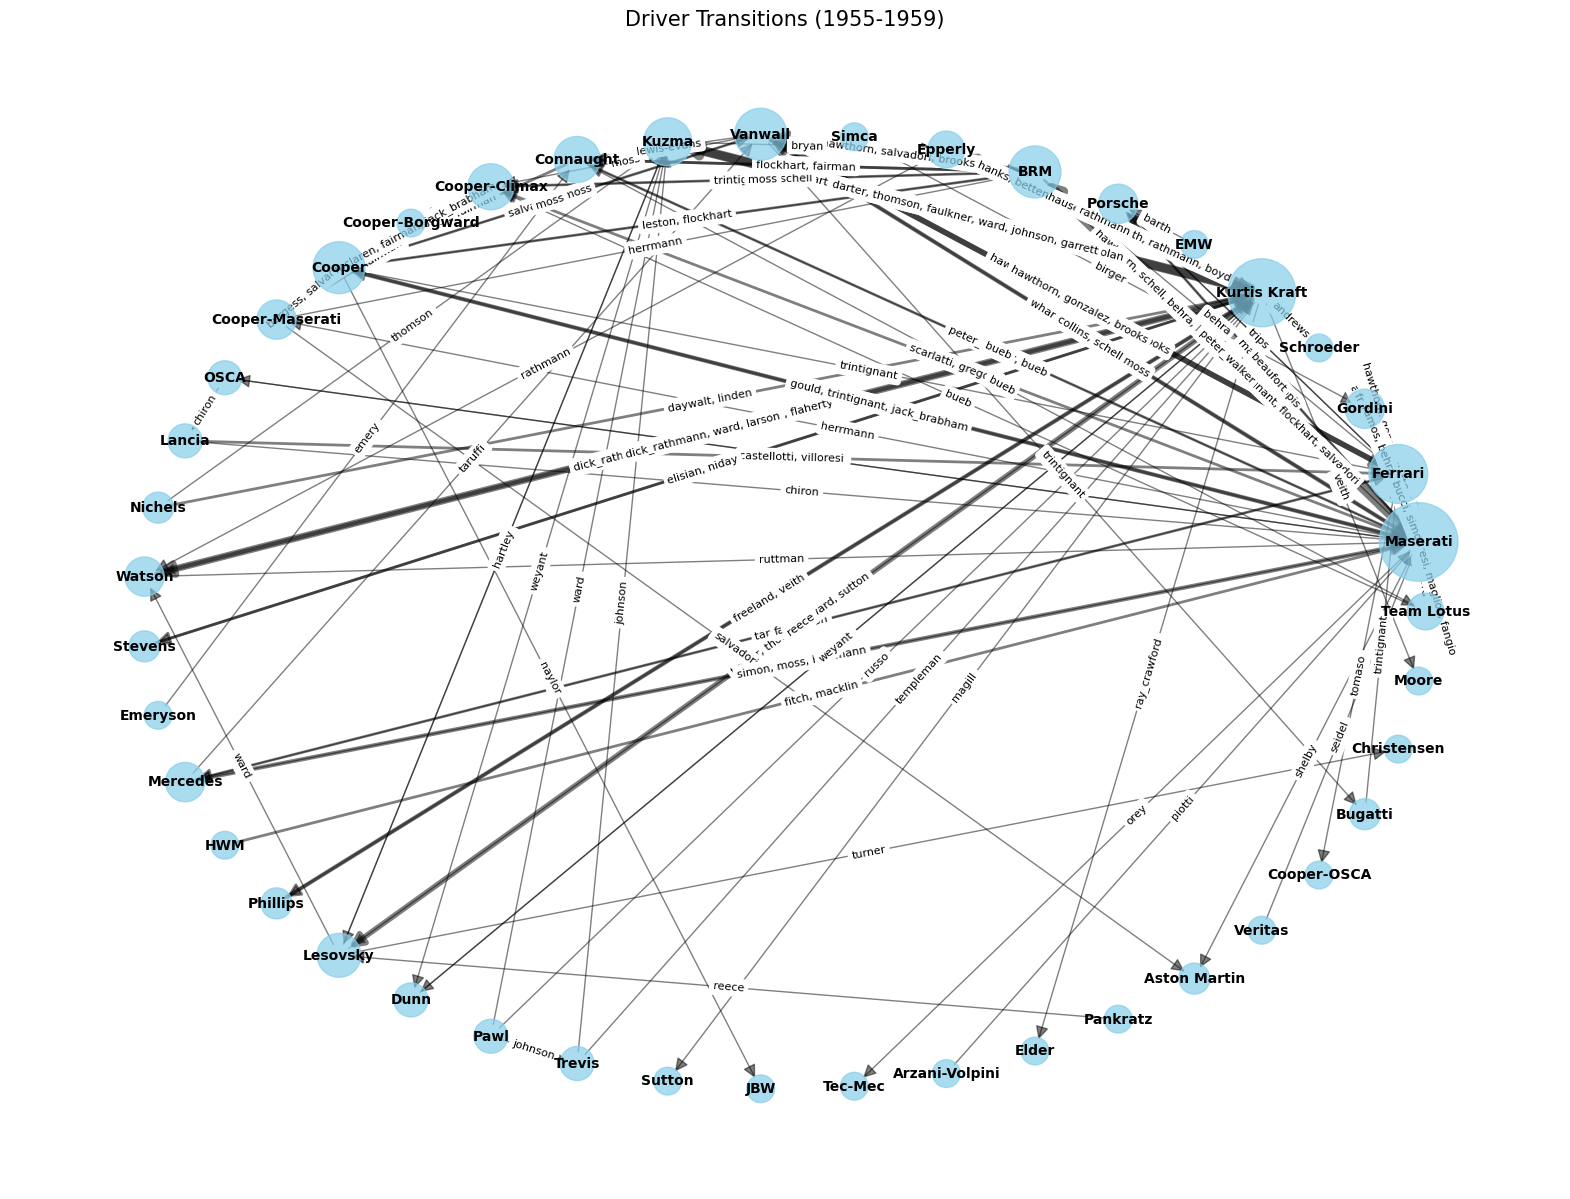

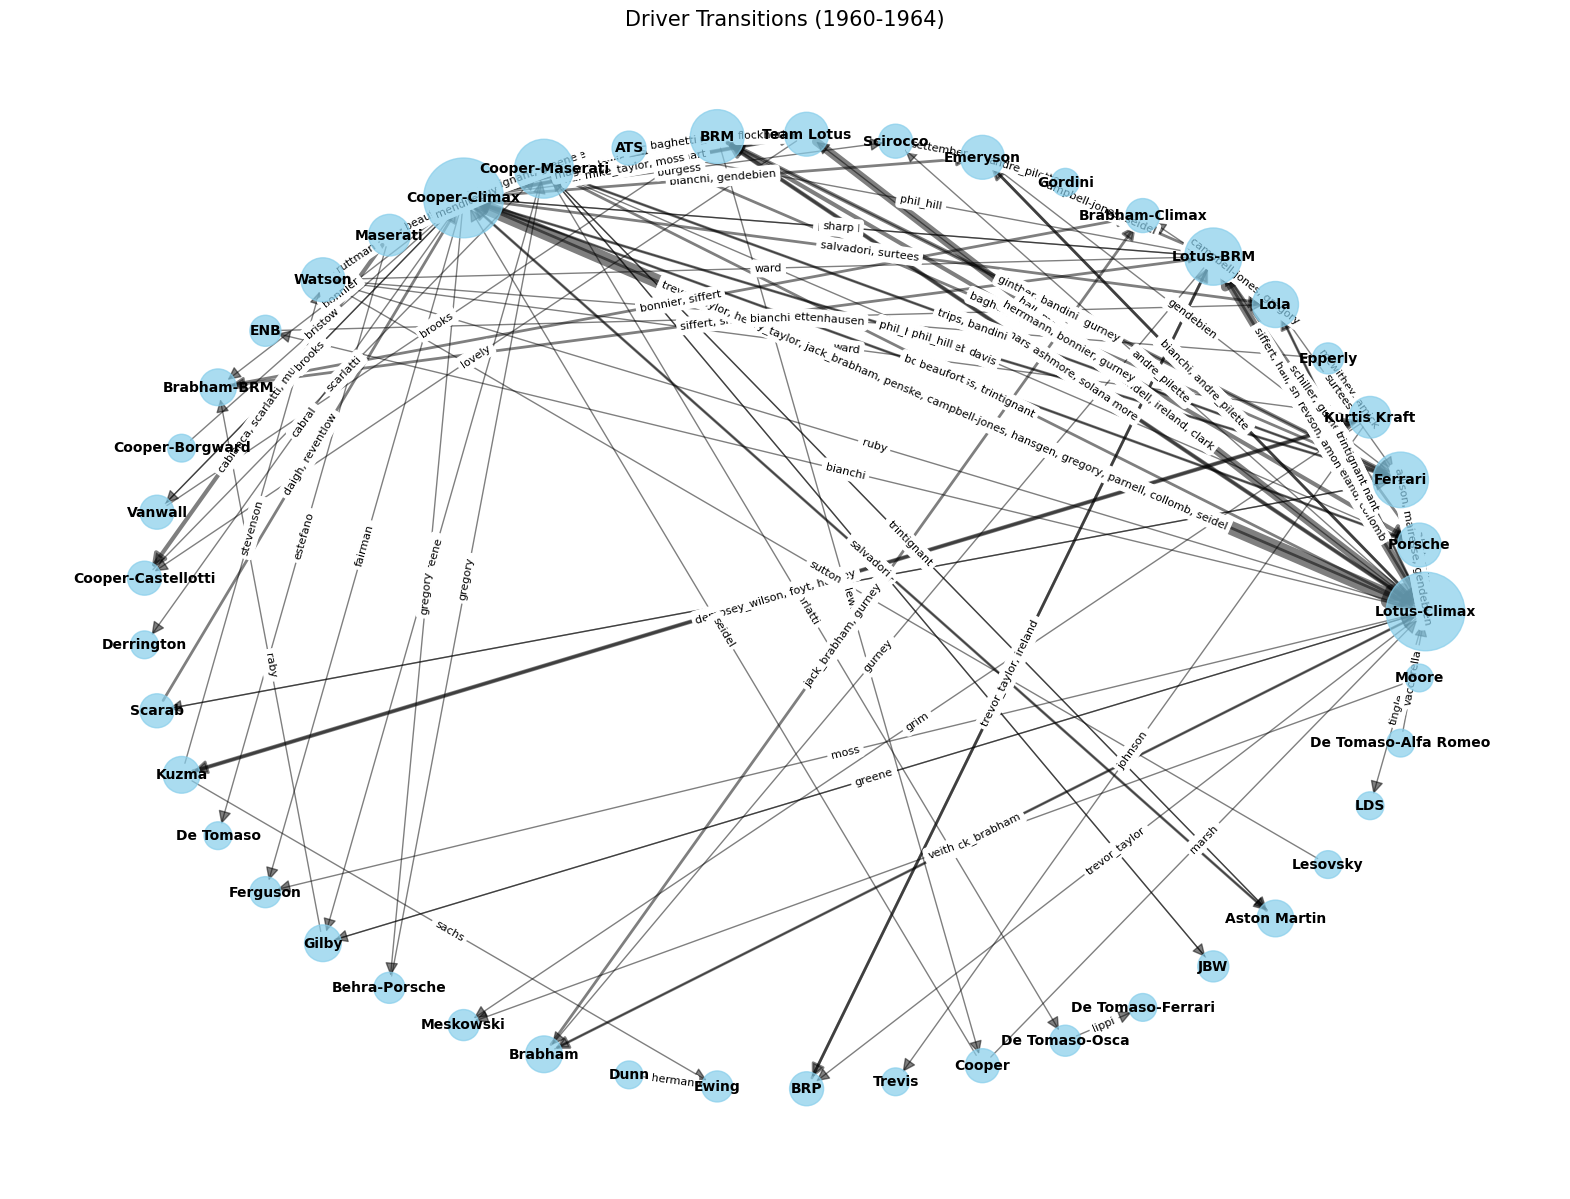

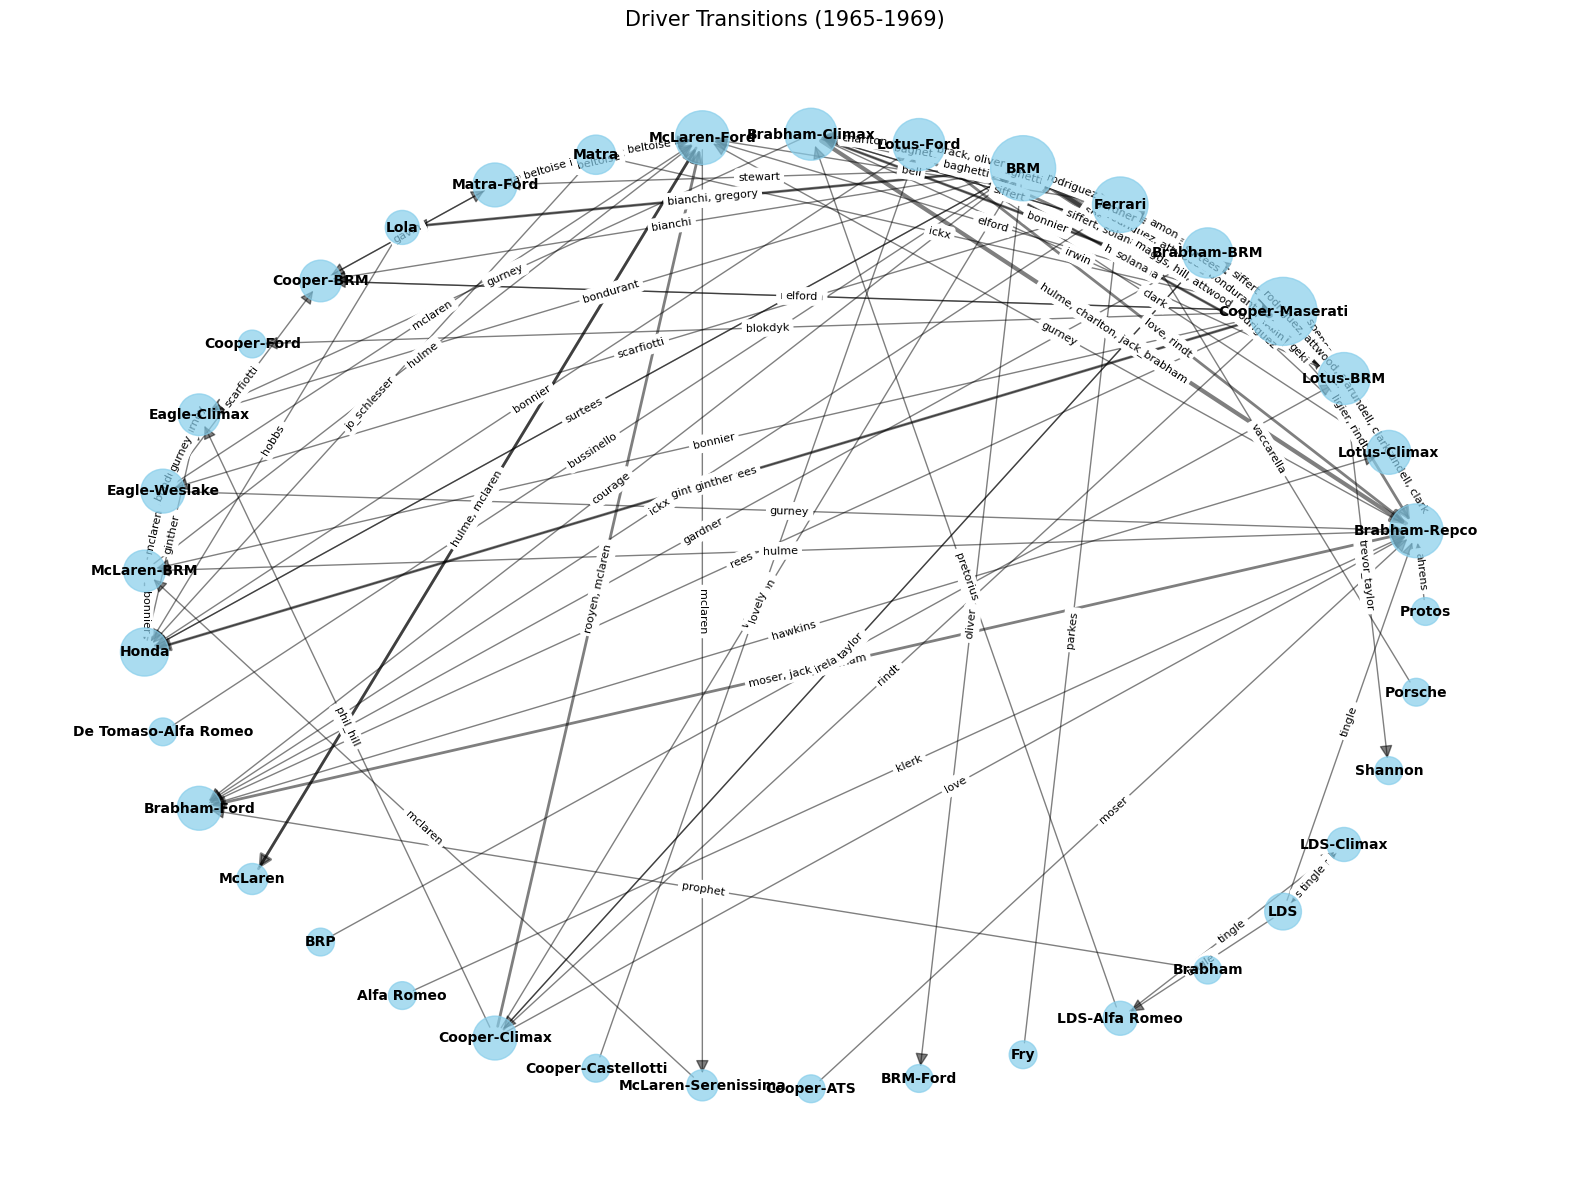

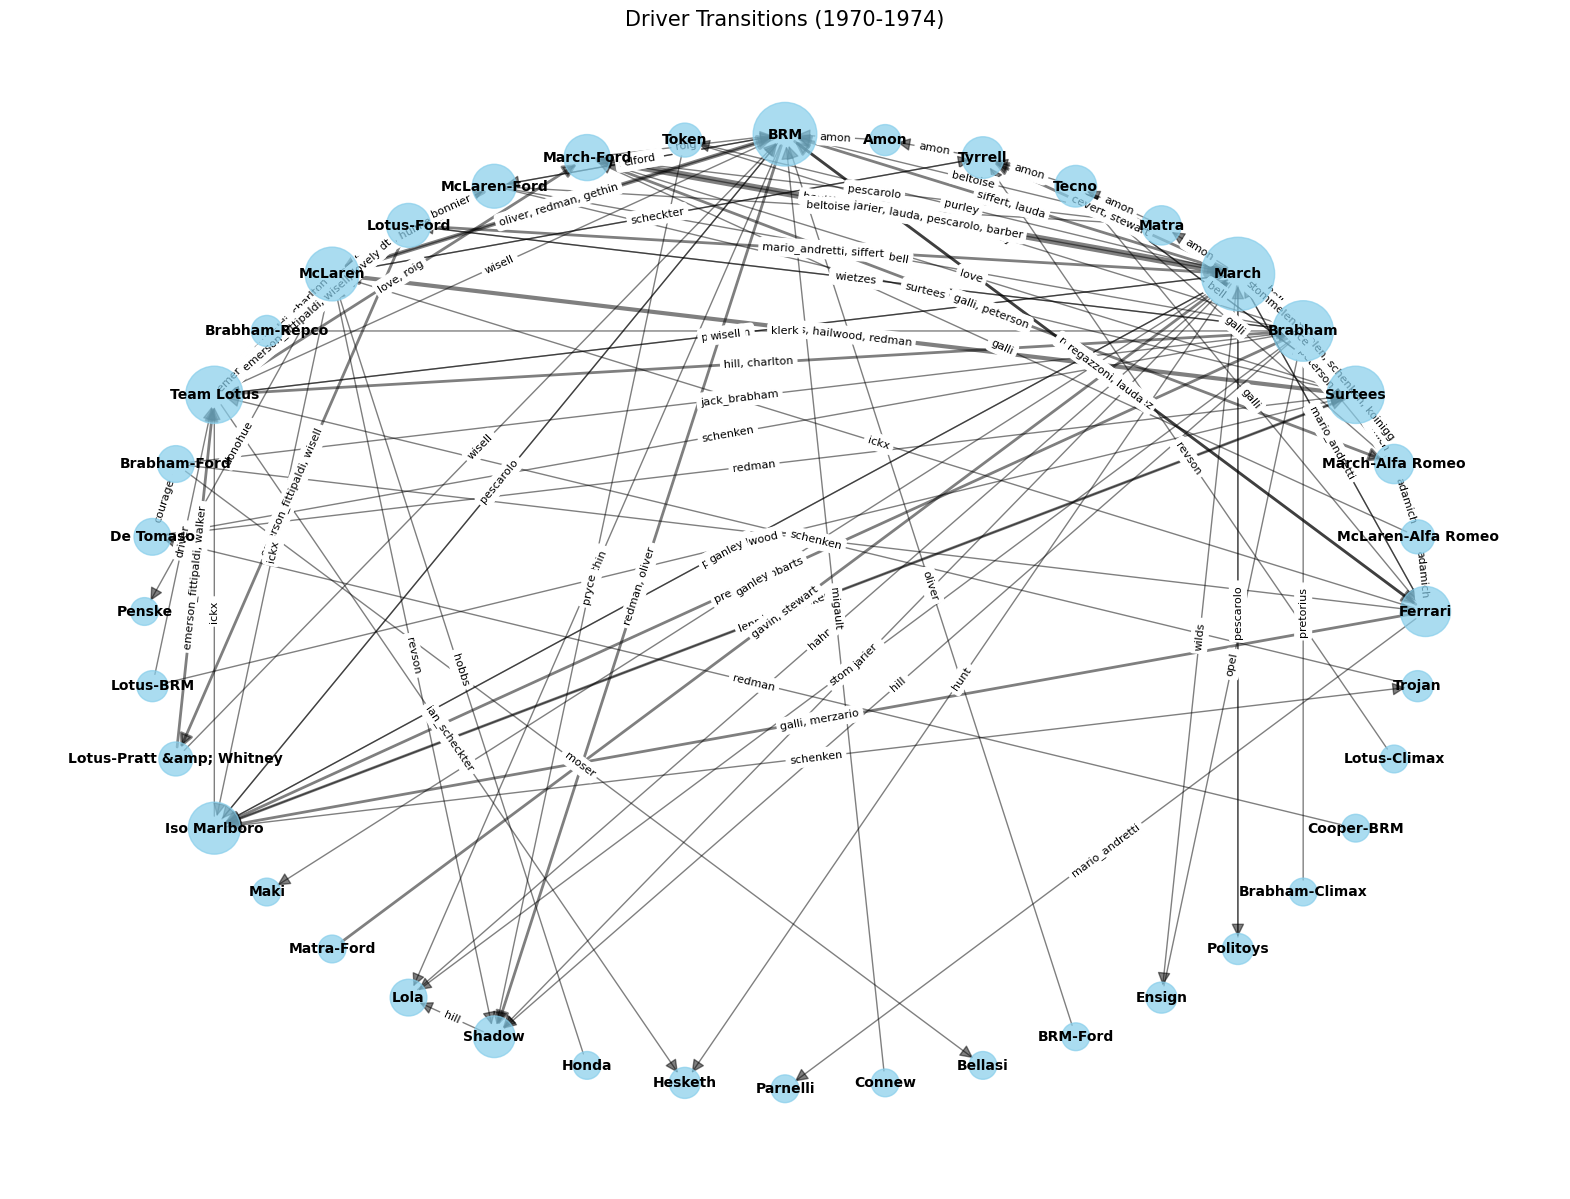

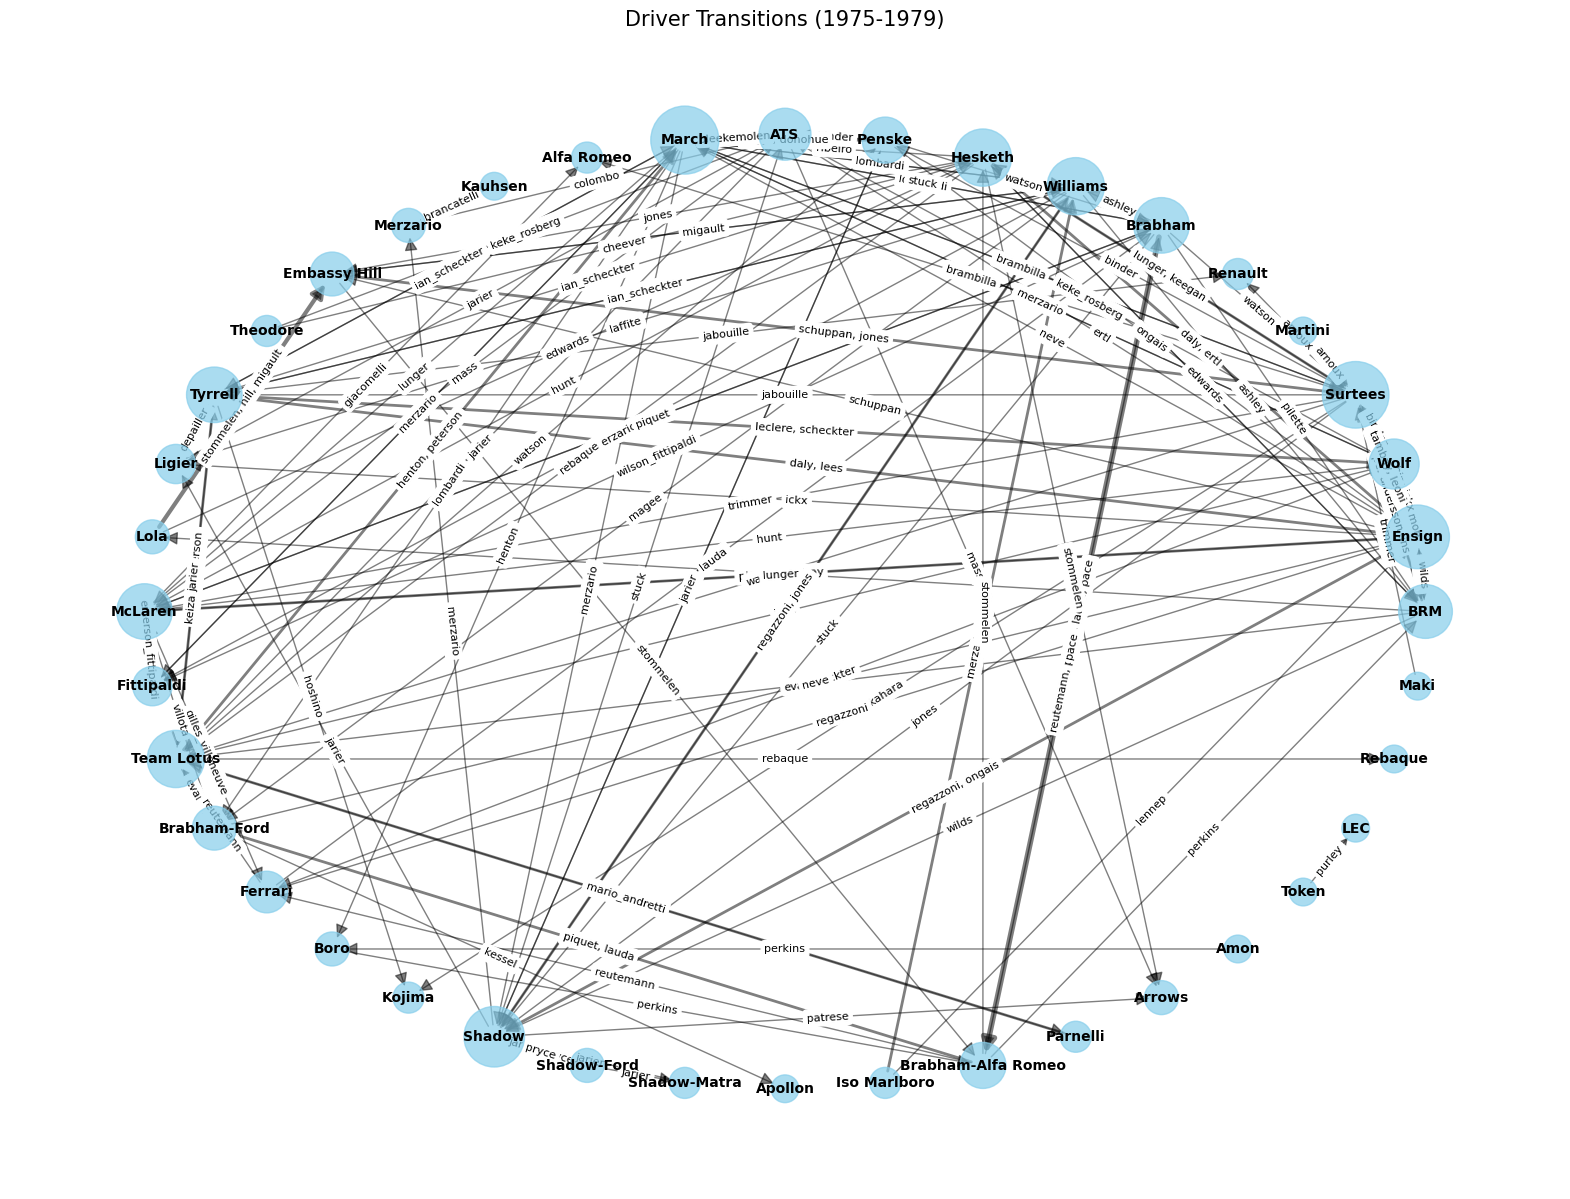

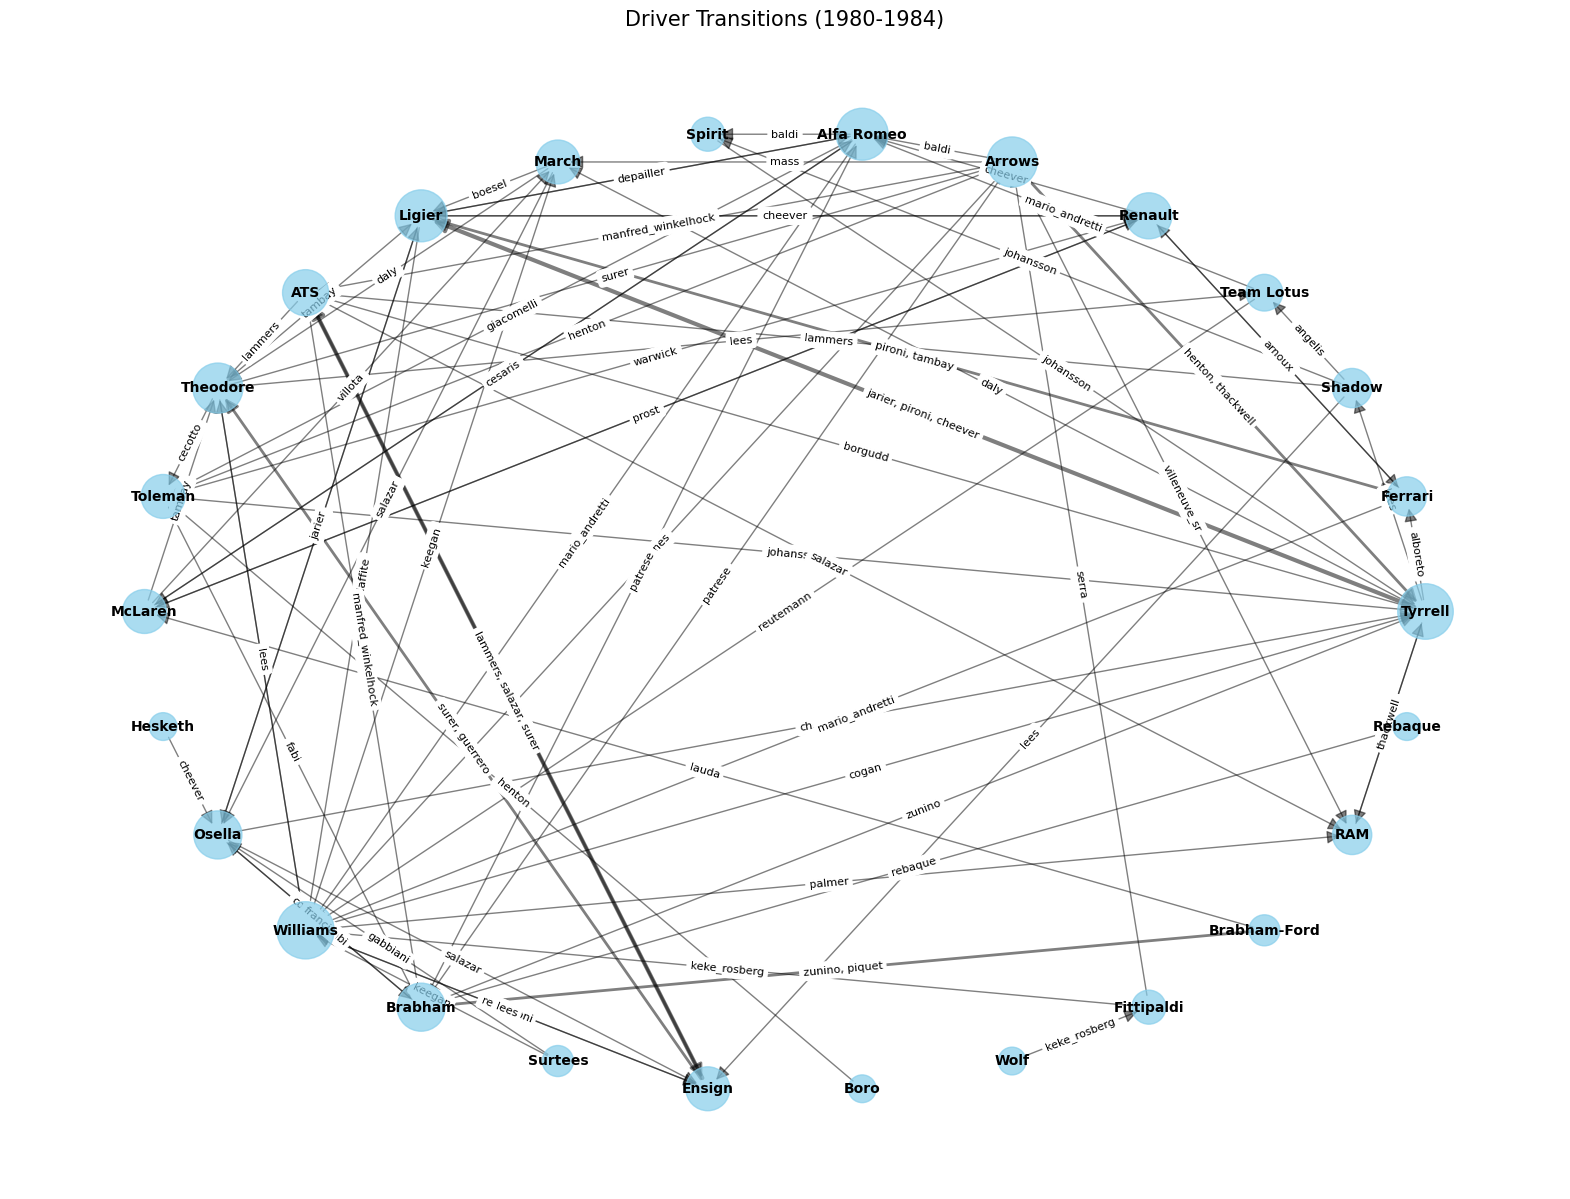

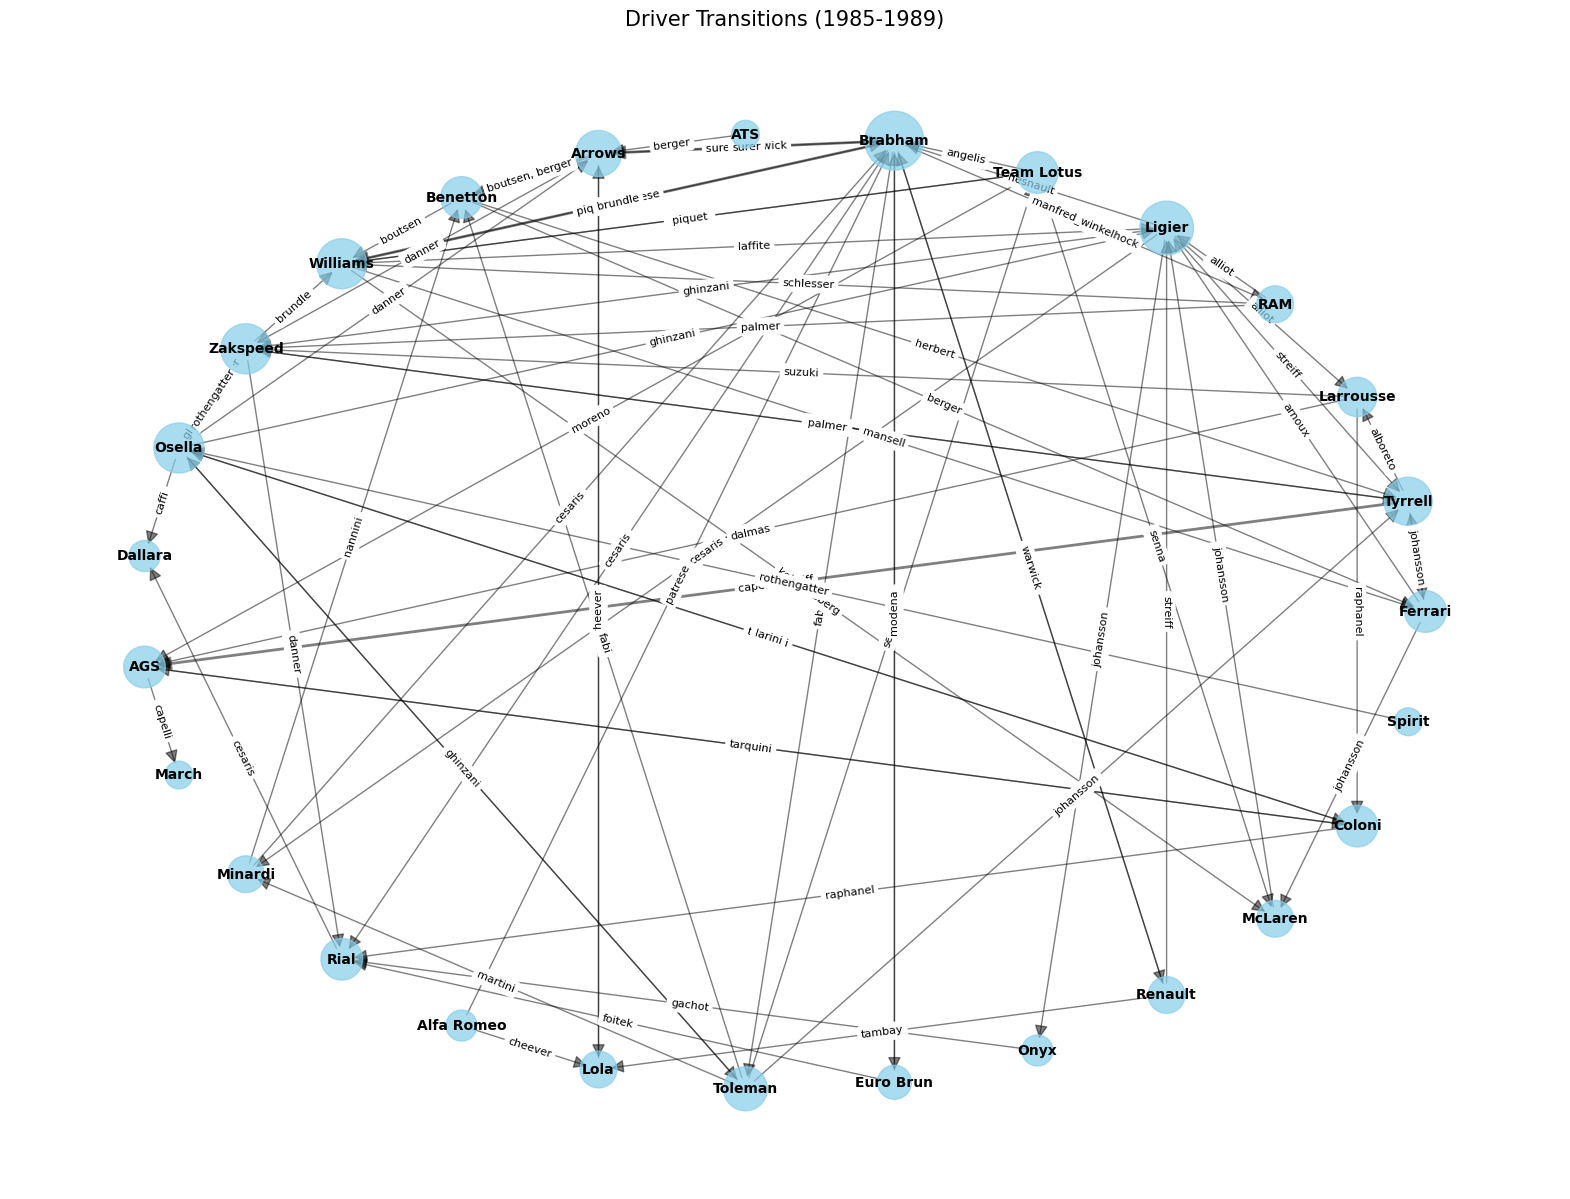

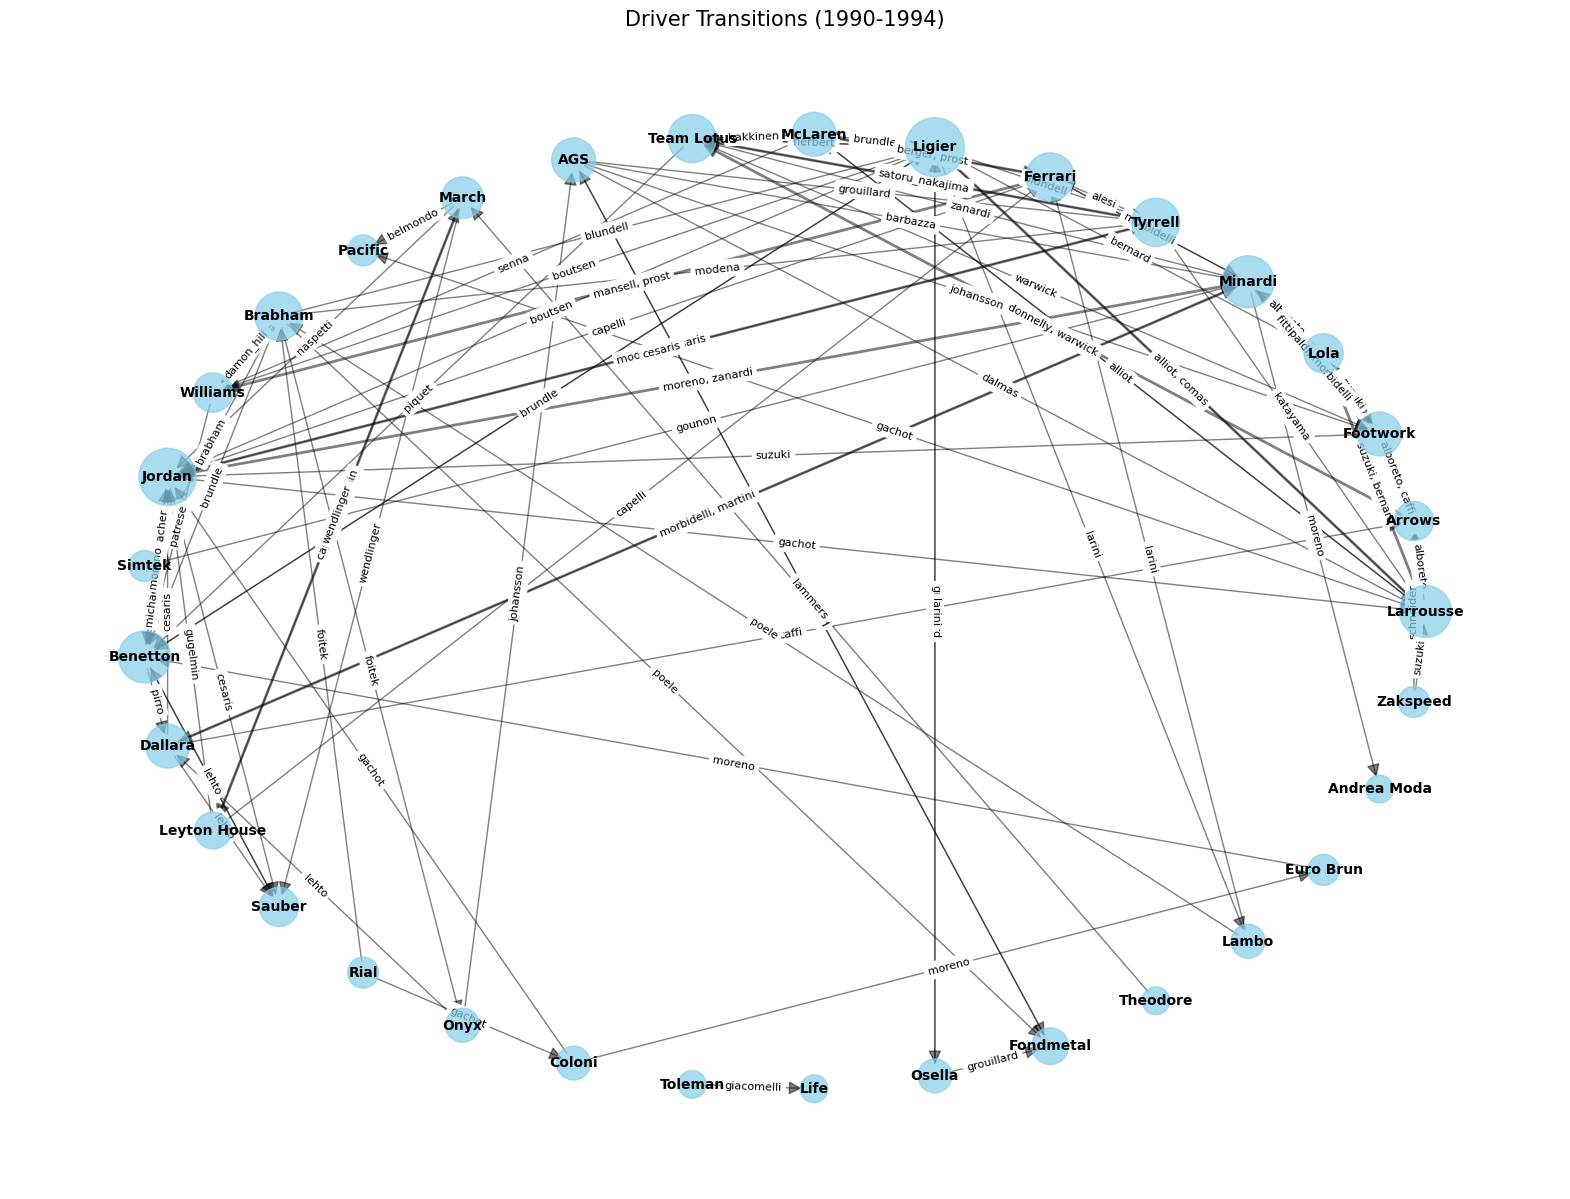

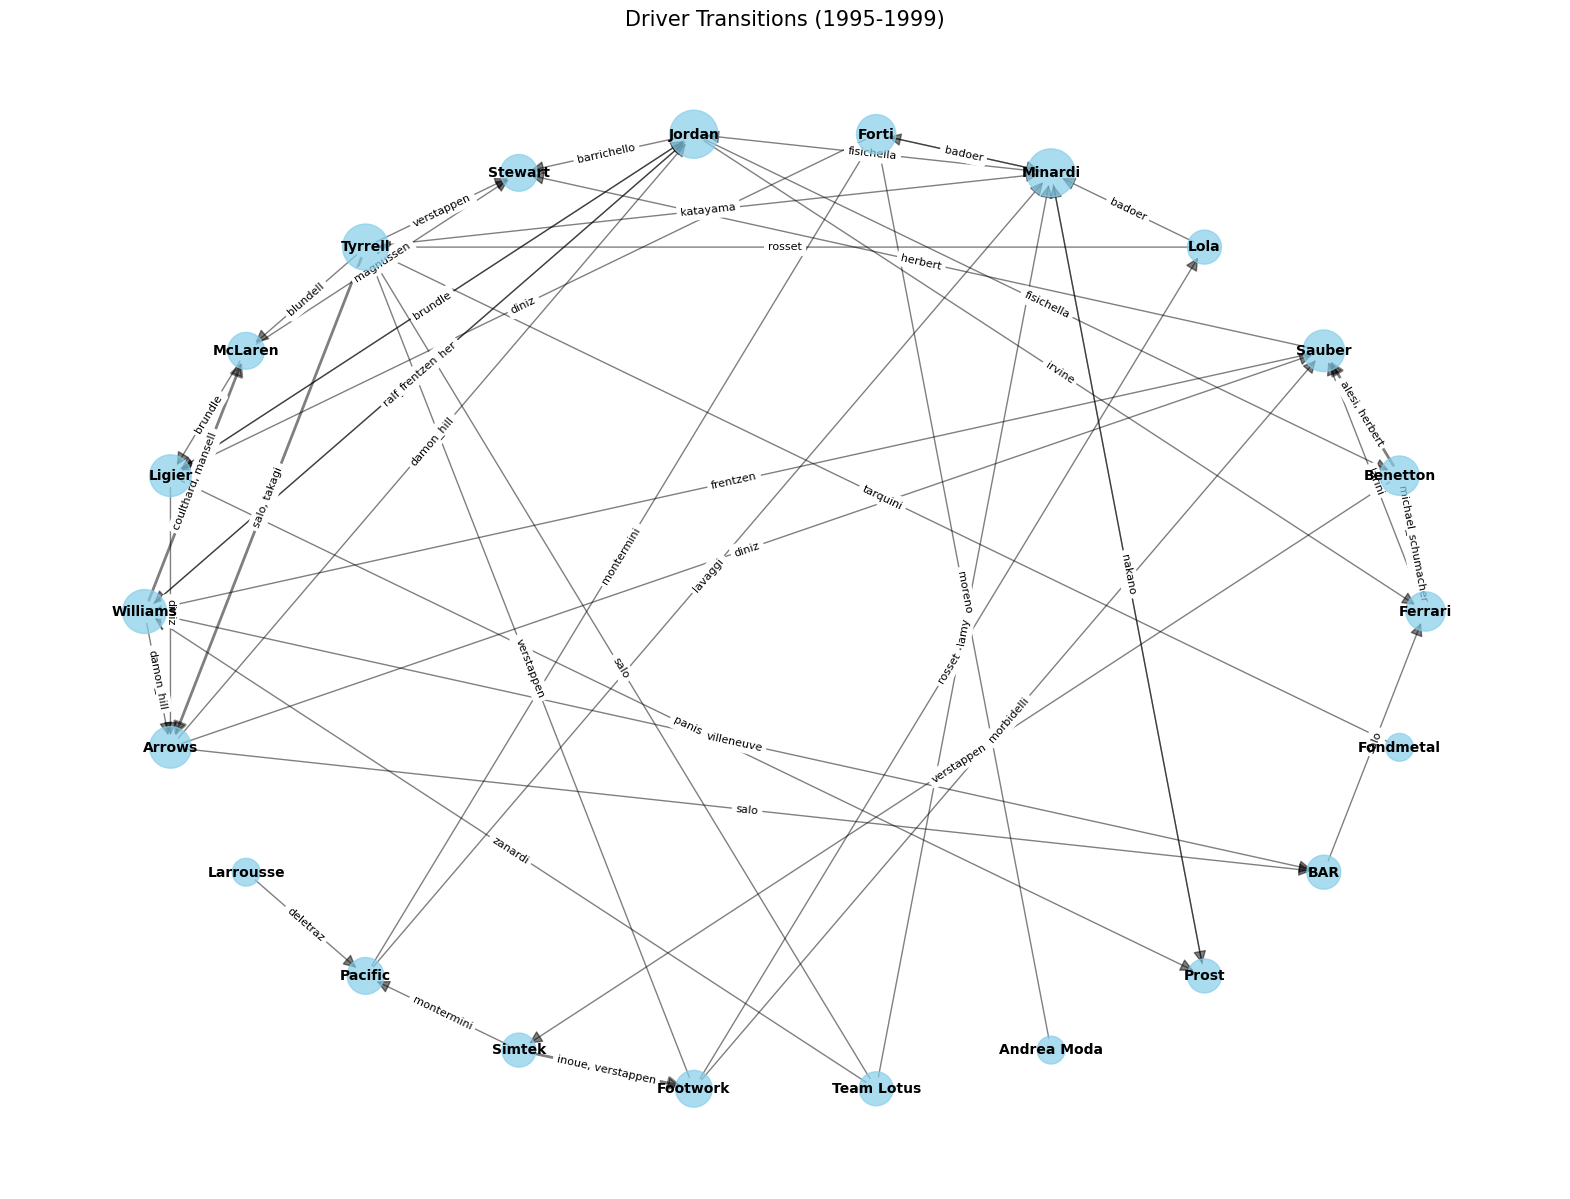

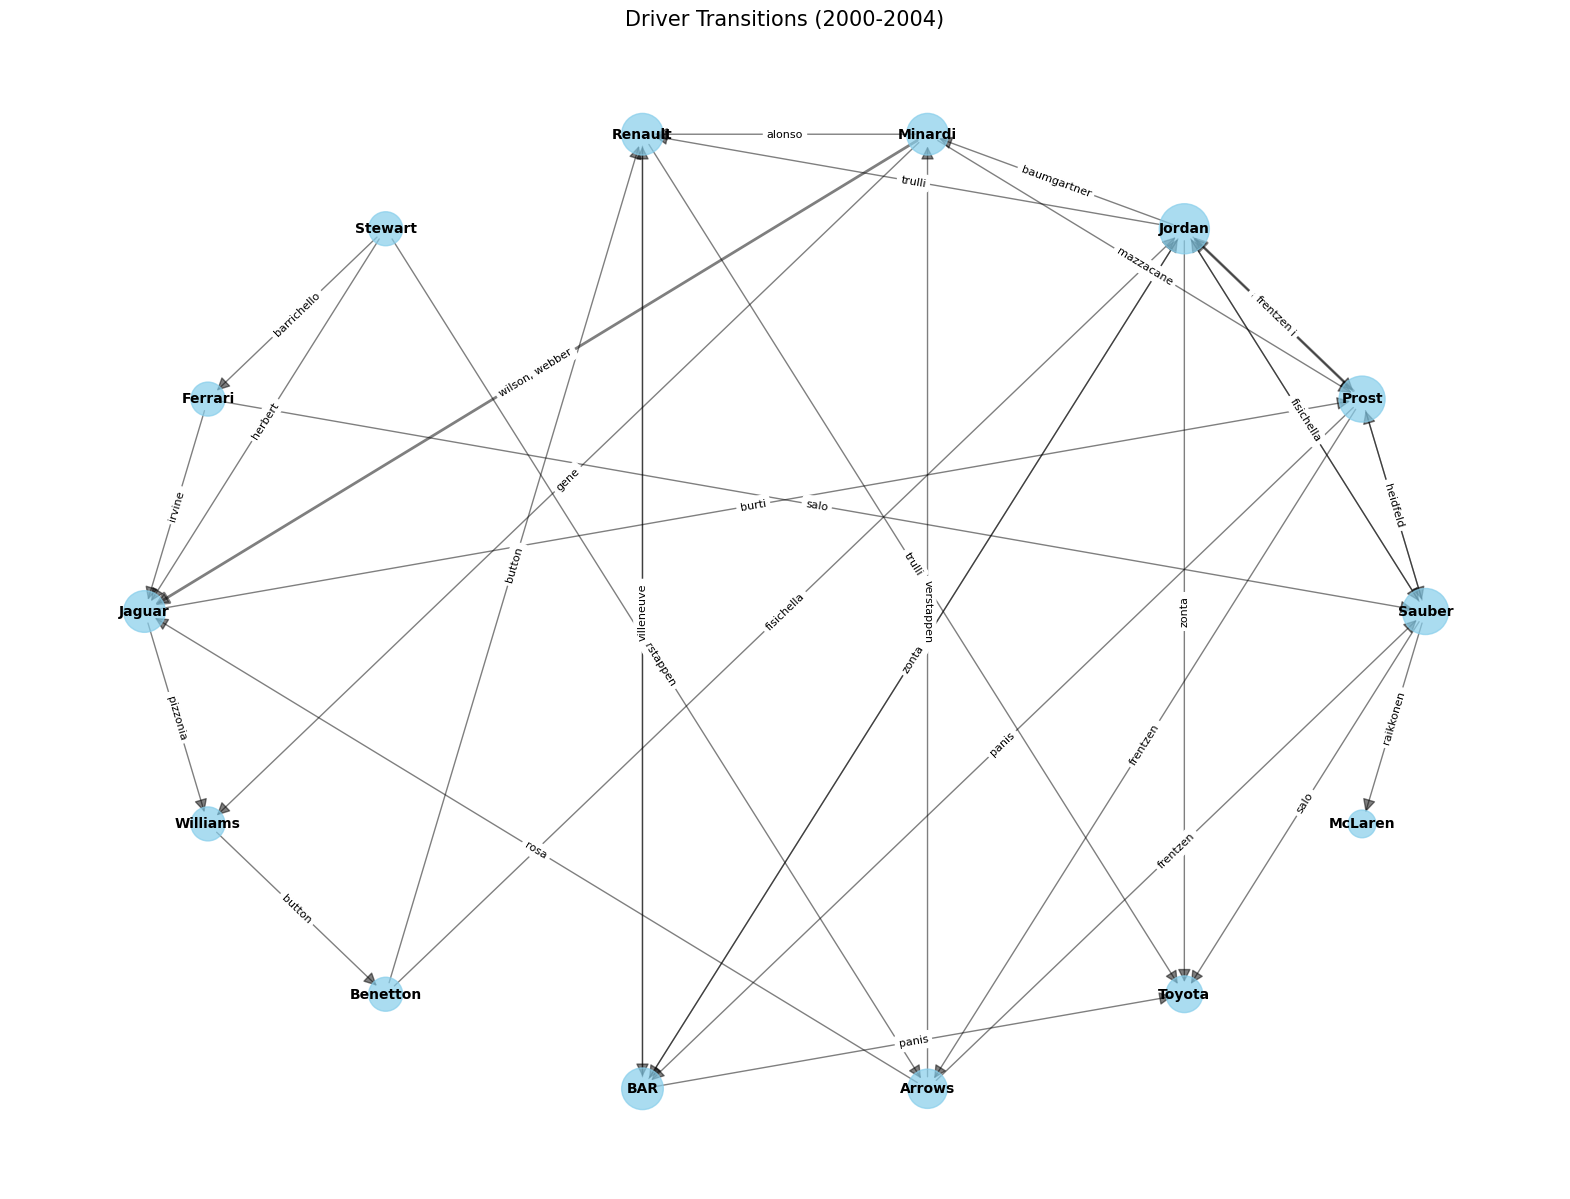

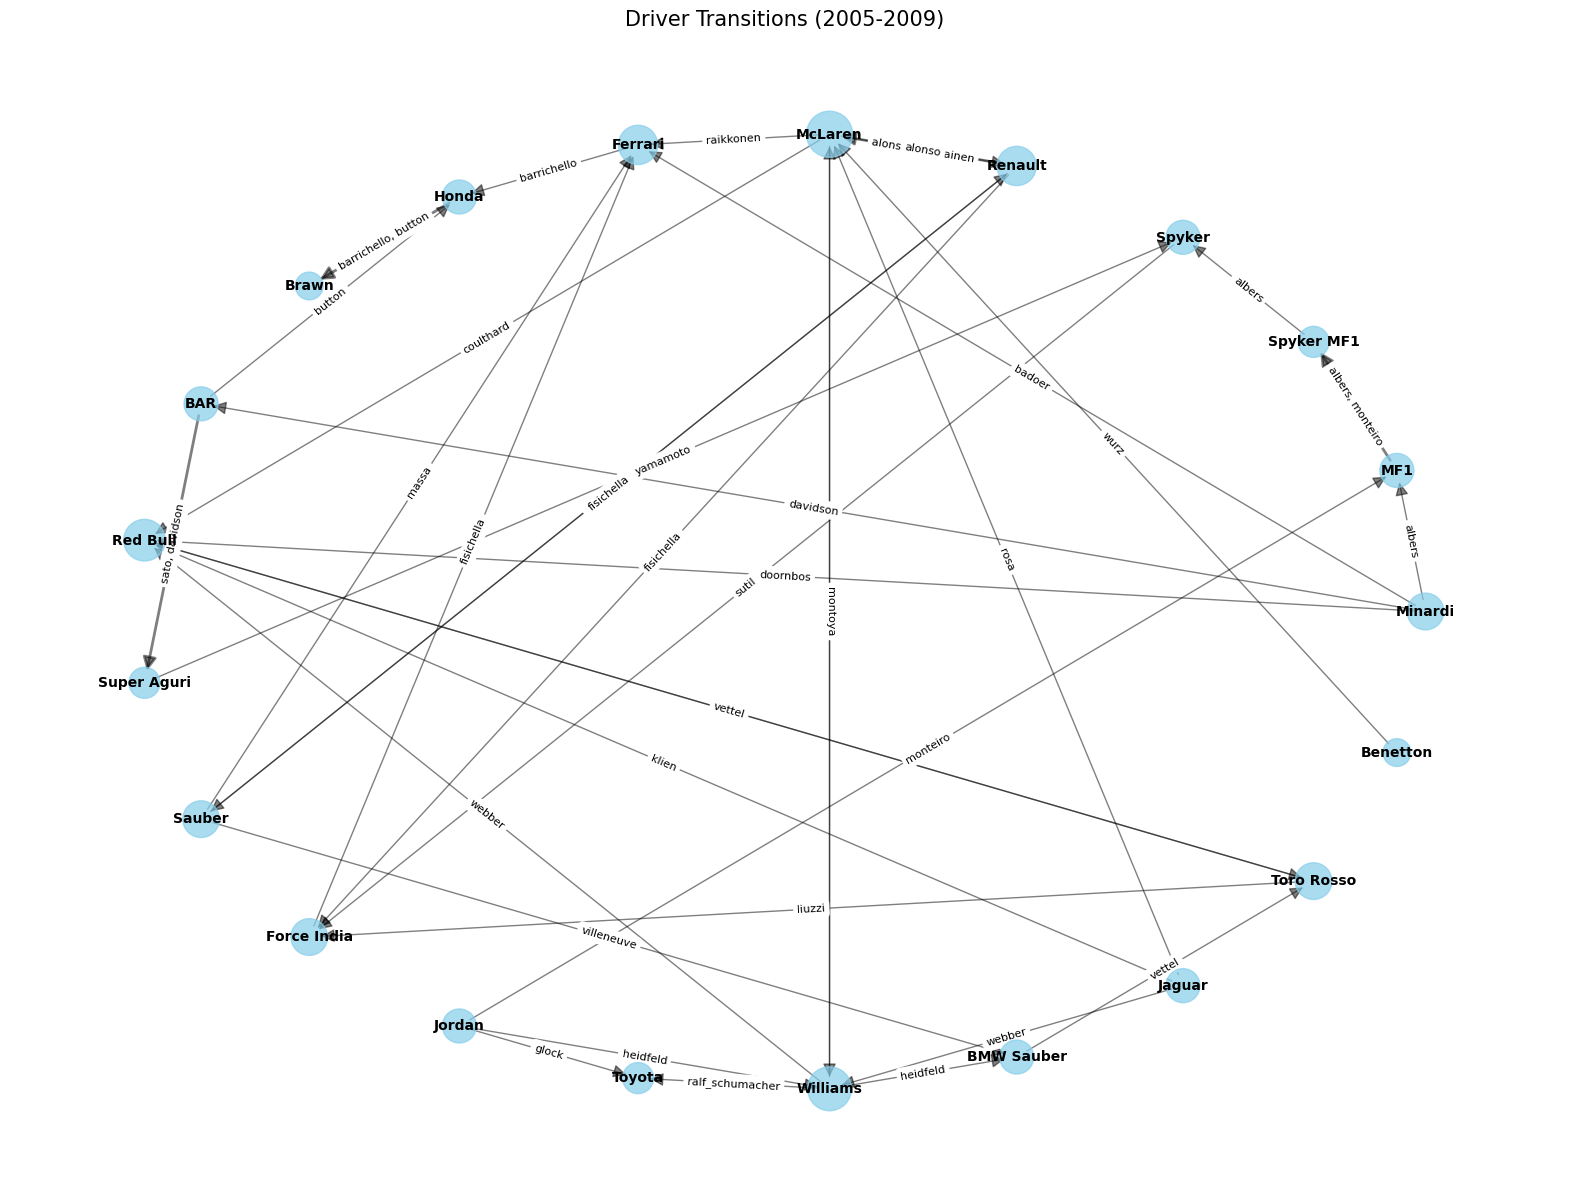

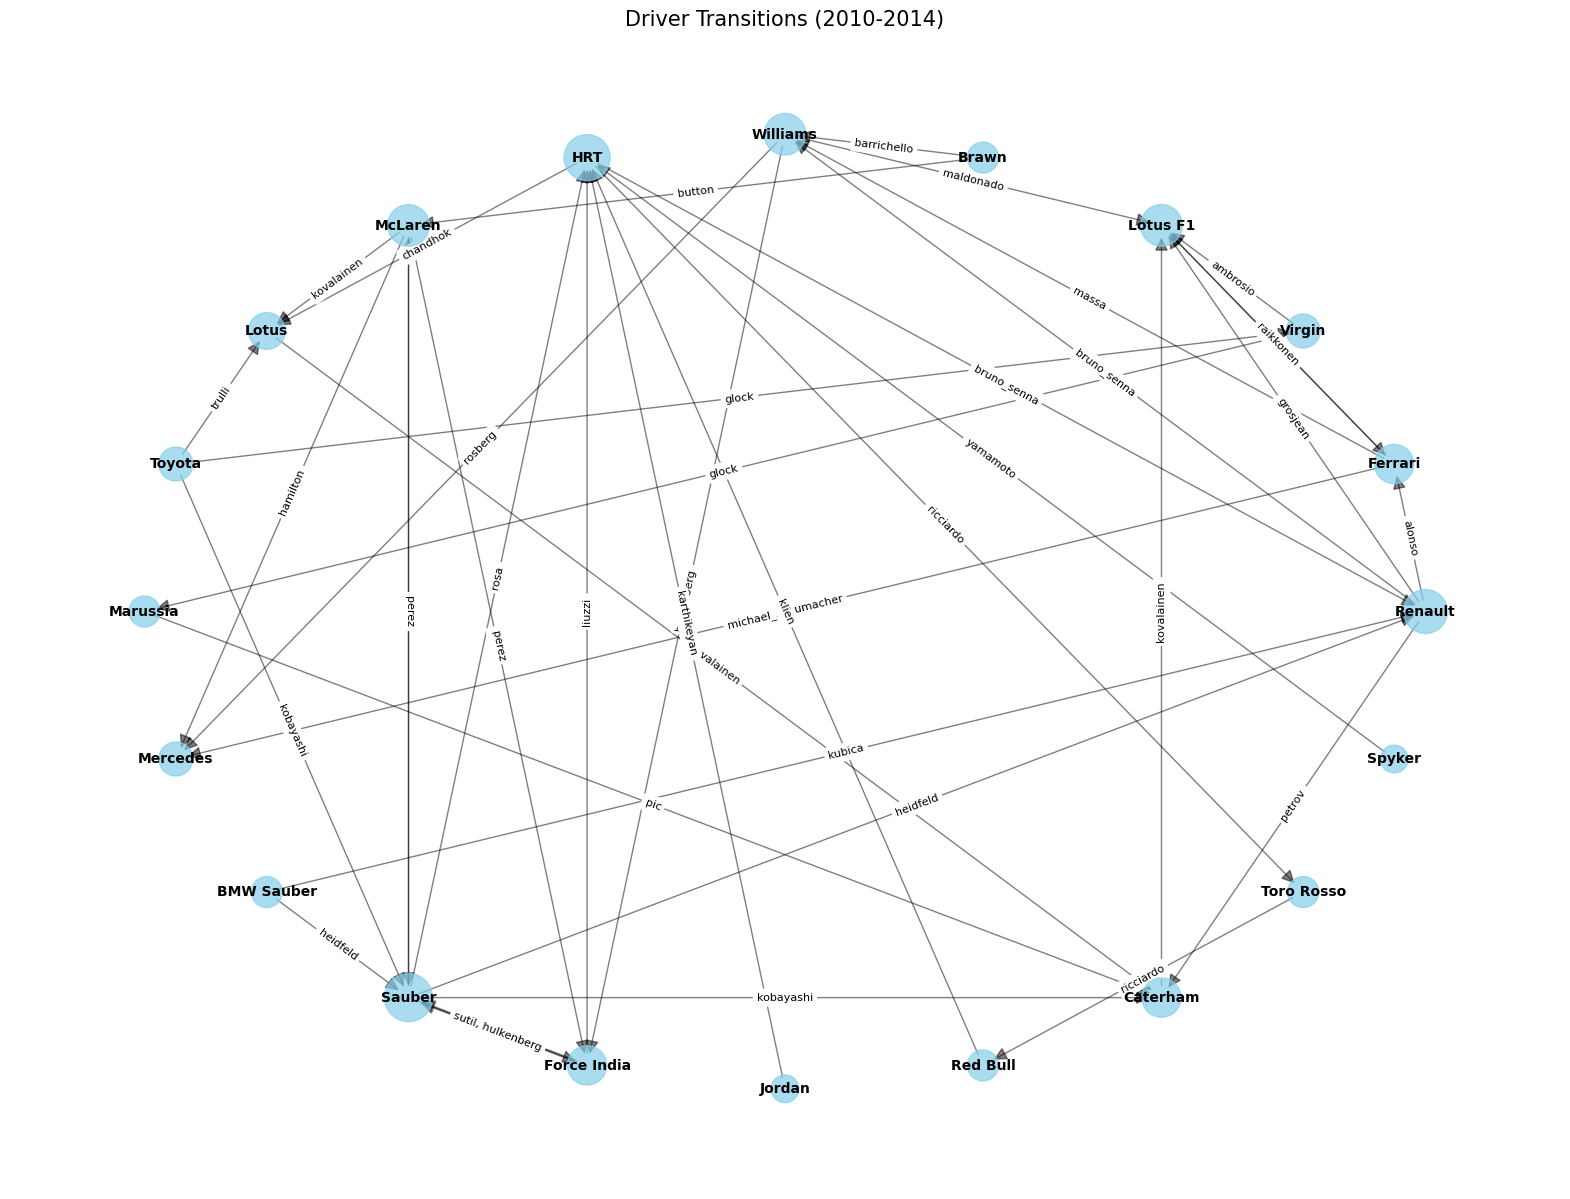

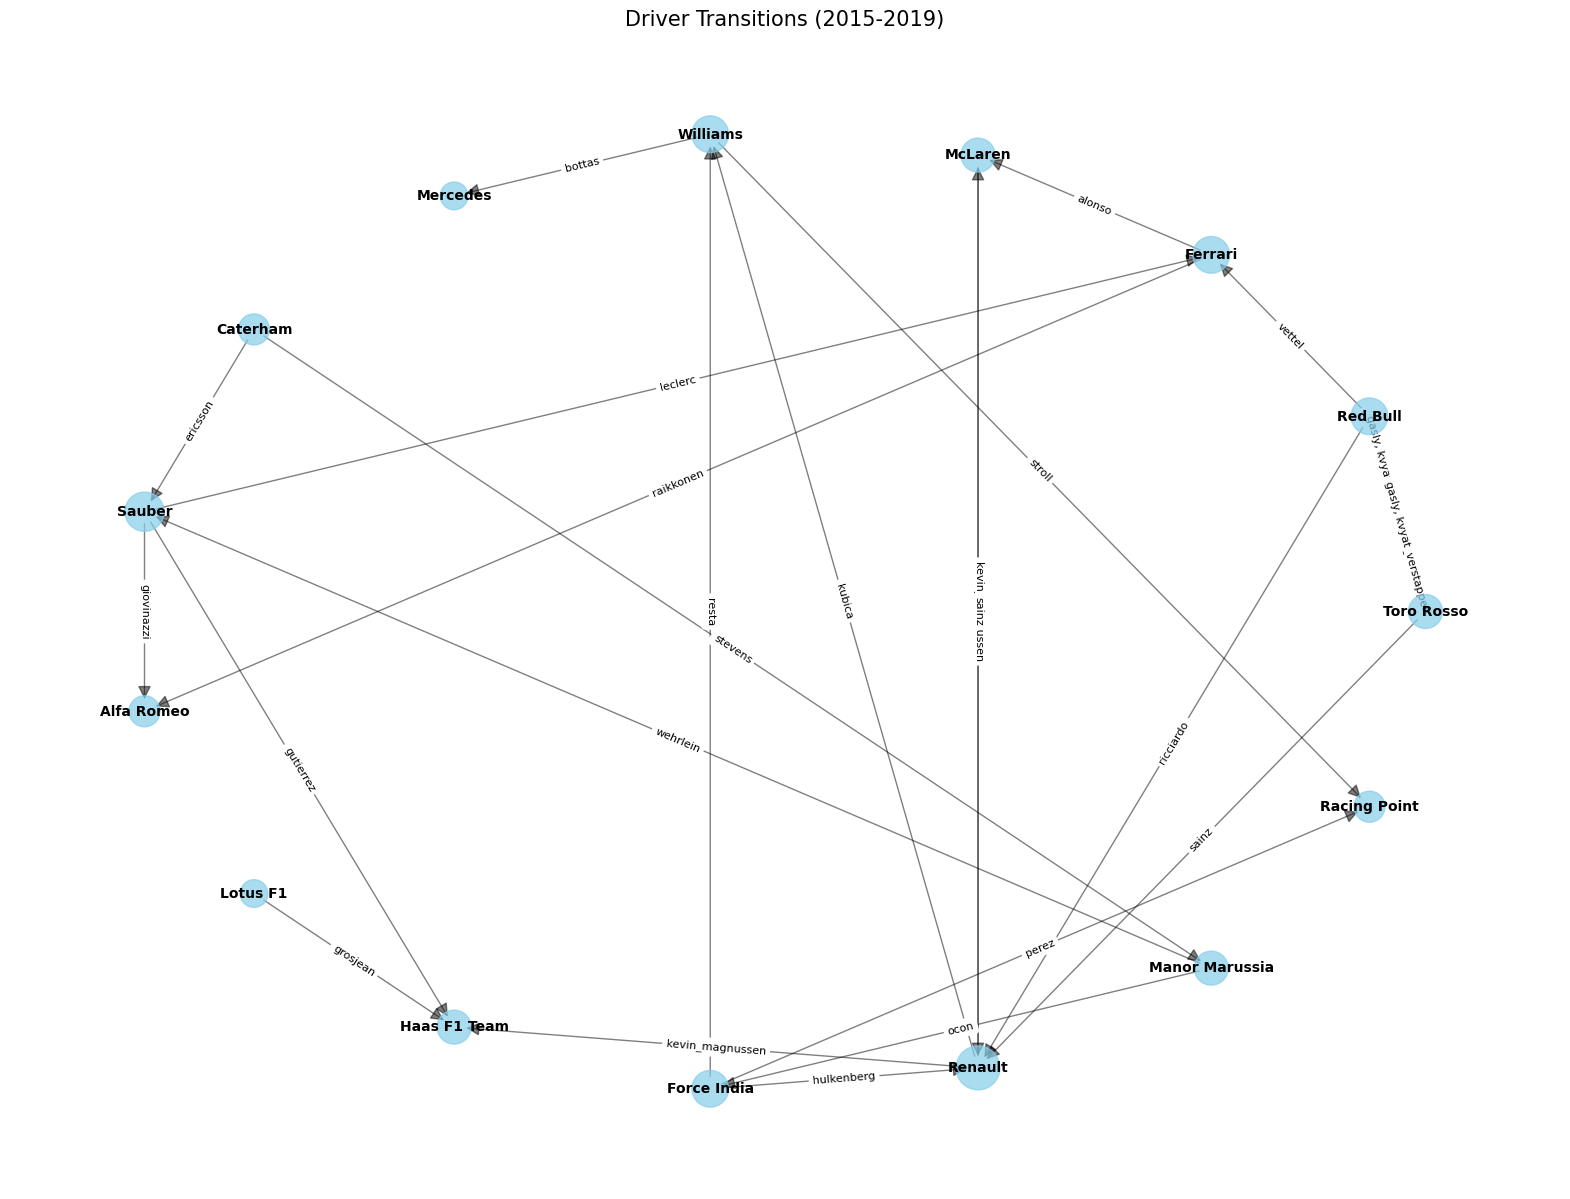

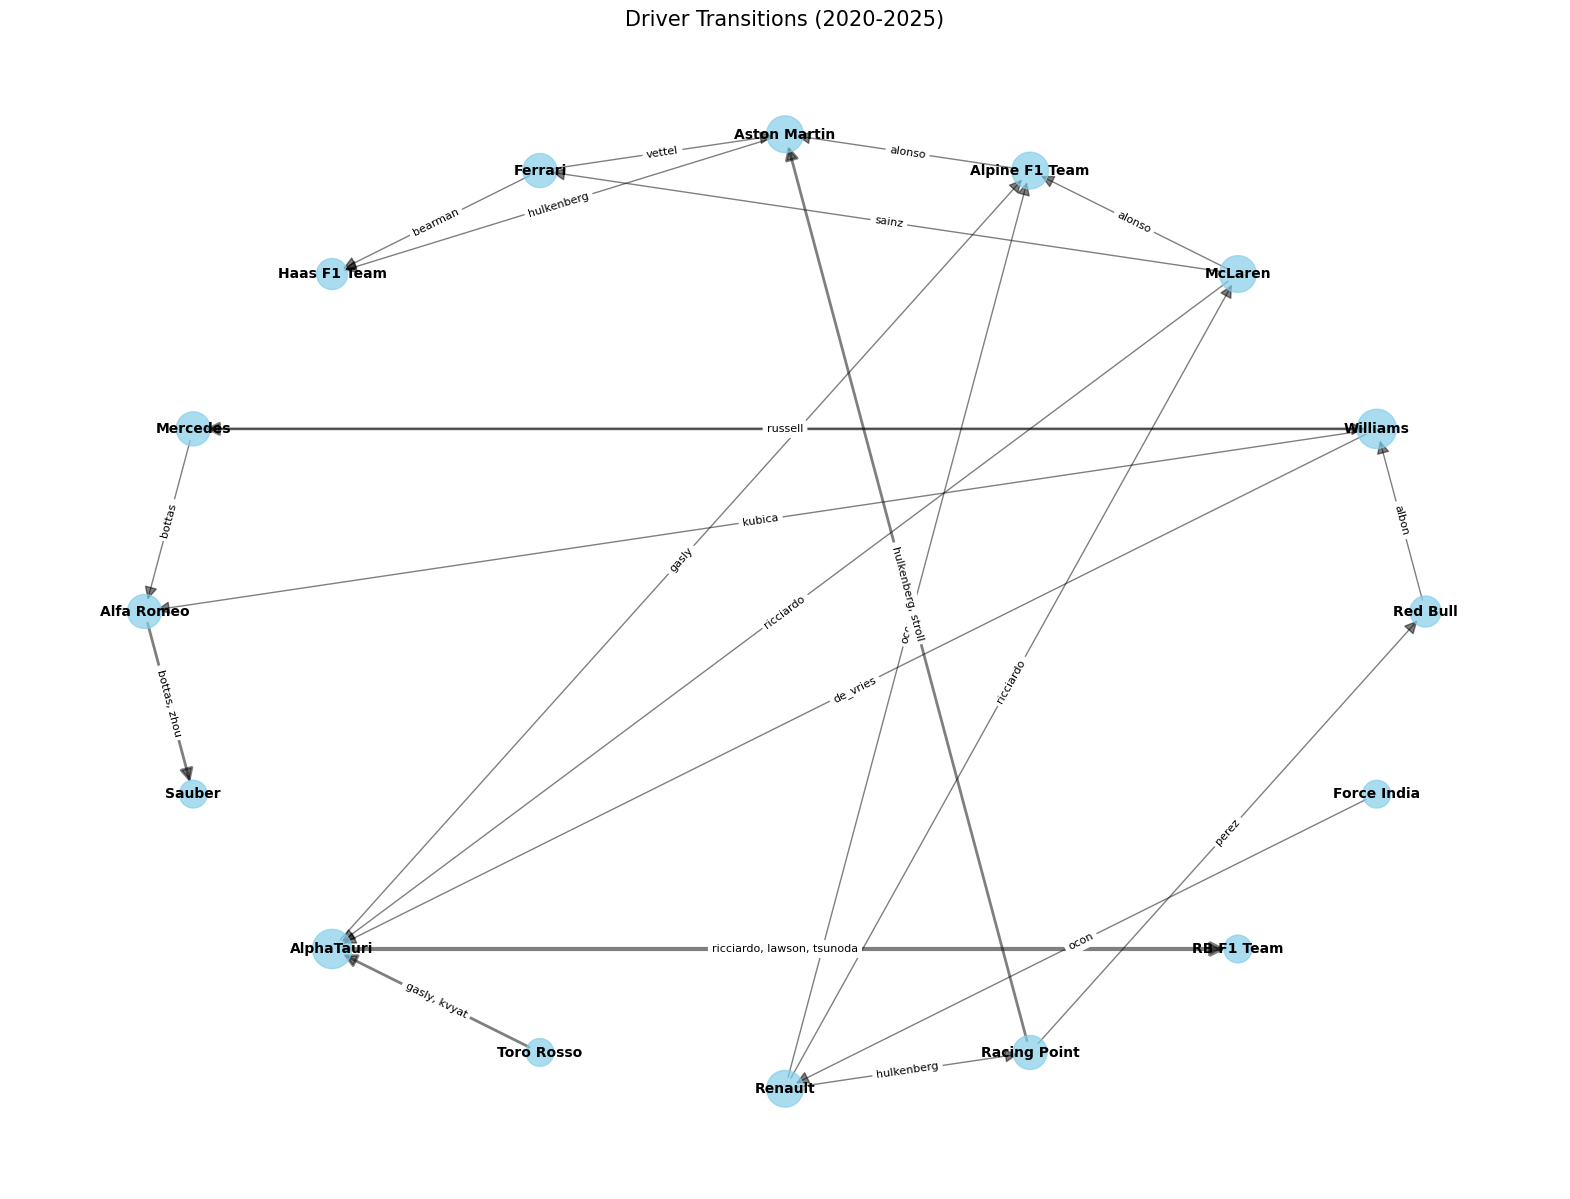

In [7]:
import networkx as nx


eras = [(1950, 1954), (1955, 1959), (1960, 1964), 
        (1965, 1969), (1970, 1974), (1975, 1979), 
        (1980, 1984), (1985, 1989), (1990, 1994), 
        (1995, 1999), (2000, 2004), (2005, 2009), 
        (2010, 2014), (2015, 2019), (2020, 2025)] # Modify as needed

def plot_era_subgraph(df_transitions, start_year, end_year):
    # Filter transitions for the specific era
    era_df = df_transitions[(df_transitions['year'] >= start_year) & (df_transitions['year'] <= end_year)]
    
    # Create Network Graph
    G = nx.DiGraph()
    
    # Add edges with driver info
    for _, row in era_df.iterrows():
        from_team = row['from_team']
        to_team = row['to_team']
        driver = row['driver']
        
        if G.has_edge(from_team, to_team):
            G[from_team][to_team]['drivers'].add(driver)
            G[from_team][to_team]['weight'] += 1
        else:
            G.add_edge(from_team, to_team, drivers={driver}, weight=1)
    
    plt.figure(figsize=(20, 15))
    pos = nx.circular_layout(G)  # Circular layout for clearer separation

    # Node and Edge sizes
    node_sizes = [300 + 100 * G.degree(n) for n in G.nodes()]
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Draw Graph
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='black', alpha=0.5, arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Add Driver Names on Edges
    edge_labels = {(u, v): ', '.join(G[u][v]['drivers']) for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

    plt.title(f"Driver Transitions ({start_year}-{end_year})", fontsize=15)
    plt.axis('off')
    plt.show()

# Plot Subgraphs for Each Era
for era in eras:
    plot_era_subgraph(df_transitions, era[0], era[1])
